# 🎓 From Scores to Seats: The Grad School ML Challenge

Welcome to the starter notebook for this beginner-friendly data science hackathon! In this challenge, your goal is to build a machine learning model that can predict whether a student will be admitted into a graduate program based on their academic profile.

This notebook will walk you through a simple end-to-end pipeline:
- Loading and exploring the data
- Preprocessing
- Training a baseline model
- Making predictions
- Preparing a submission

---

## 📦 Files
- `train.csv`: Training data (features + target)
- `test.csv`: Test data (features only)
- `SampleSubmission.csv`: Format for submitting predictions

---

## 🧠 Target Variable
- `Admitted`: 1 if the student was admitted, 0 otherwise

Let's get started! 🚀


In [1]:
# 📚 Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


In [2]:
# 📥 Load the Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")

# Peek at the data
train.head()


,ID,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admitted,Age,Location,First_Generation
0,ID_000001,319.0,111.0,4,4.78,4.89,9.51,1,1,26,South America,1
1,ID_000002,327.0,113.0,5,4.24,4.74,10.19,1,1,23,Africa,1
2,ID_000003,323.0,110.0,4,3.43,2.99,8.81,1,1,32,South America,0
3,ID_000004,321.0,105.0,3,3.41,3.38,NaN,0,0,34,Africa,1
4,ID_000005,316.0,108.0,3,NaN,4.80,NaN,1,1,30,North America,1


## 🔍 Exploratory Data Analysis (EDA)
Let’s explore the training data to understand the features and target.


In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 3600 non-null   object 
 1   GRE Score          3240 non-null   float64
 2   TOEFL Score        3240 non-null   float64
 3   University Rating  3600 non-null   int64  
 4   SOP                3240 non-null   float64
 5   LOR                3600 non-null   float64
 6   CGPA               3240 non-null   float64
 7   Research           3600 non-null   int64  
 8   Admitted           3600 non-null   int64  
 9   Age                3600 non-null   int64  
 10  Location           3600 non-null   object 
 11  First_Generation   3600 non-null   int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 337.6+ KB


### 🏷️ Encoding 'Location'

We used **one-hot encoding** to convert the categorical `Location` column into numeric format. This creates binary columns for each unique location (excluding one to avoid redundancy):


In [4]:
# Check for missing values
train.isnull().sum()

ID                     0
GRE Score            360
TOEFL Score          360
University Rating      0
SOP                  360
LOR                    0
CGPA                 360
Research               0
Admitted               0
Age                    0
Location               0
First_Generation       0
dtype: int64

In [5]:
# Fill missing numeric values with the mean of each column
numeric_cols = ['GRE Score', 'TOEFL Score', 'SOP', 'CGPA']
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())

# Double check to confirm missing values are handled
print("Remaining missing values:", train.isnull().sum().sum())


Remaining missing values: 0


In [6]:
train = pd.get_dummies(train, columns=['Location'], drop_first=True)
test = pd.get_dummies(test, columns=['Location'], drop_first=True)

In [7]:
train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admitted,Age,First_Generation,...,Age_bin_Senior,GRE_bin,TOEFL_bin,CGPA_bin,GRE Score_scaled,TOEFL Score_scaled,CGPA_scaled,Academic_Score,GRE_TOEFL_interaction,GRE_outlier
0,319.0,111.0,4,4.78,4.89,9.51,1,1,26,1,...,False,2,3,3,0.310780,0.789861,0.994009,0.698216,35409.0,0
1,327.0,113.0,5,4.24,4.74,10.19,1,1,23,1,...,False,3,3,3,1.064948,1.129322,1.720205,1.304825,36951.0,0
2,323.0,110.0,4,3.43,2.99,8.81,1,1,32,0,...,True,2,2,2,0.687864,0.620130,0.246453,0.518149,35530.0,0
3,321.0,105.0,3,3.41,3.38,8.60,0,0,34,1,...,True,2,1,1,0.499322,-0.228524,0.022186,0.097662,33705.0,0
4,316.0,108.0,3,3.40,4.80,8.60,1,1,30,1,...,False,1,2,1,0.027967,0.280669,0.022186,0.110274,34128.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,318.0,109.0,2,3.62,3.99,8.76,1,1,22,0,...,False,2,2,2,0.216509,0.450399,0.193056,0.286655,34662.0,0
3596,313.0,98.0,4,3.09,3.86,9.25,1,1,27,0,...,False,1,0,3,-0.254846,-1.416639,0.716345,-0.318380,30674.0,0
3597,316.0,118.0,4,4.51,3.35,9.23,1,1,22,0,...,False,1,3,3,0.027967,1.977976,0.694986,0.900310,37288.0,0
3598,322.0,106.0,5,4.04,3.86,9.27,1,1,27,1,...,False,2,1,3,0.593593,-0.058793,0.737704,0.424168,34132.0,0


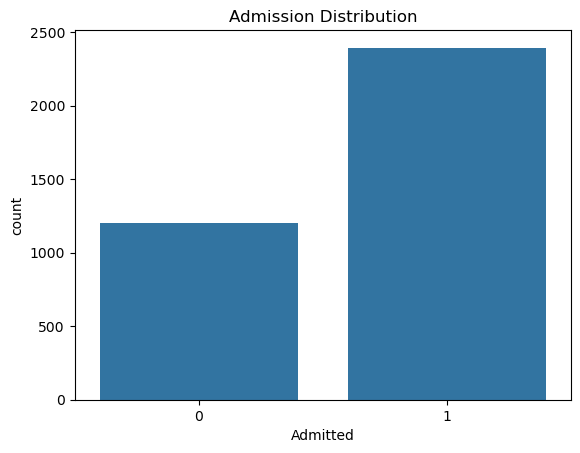

In [8]:
# Distribution of target variable
sns.countplot(x='Admitted', data=train)
plt.title("Admission Distribution")
plt.show()


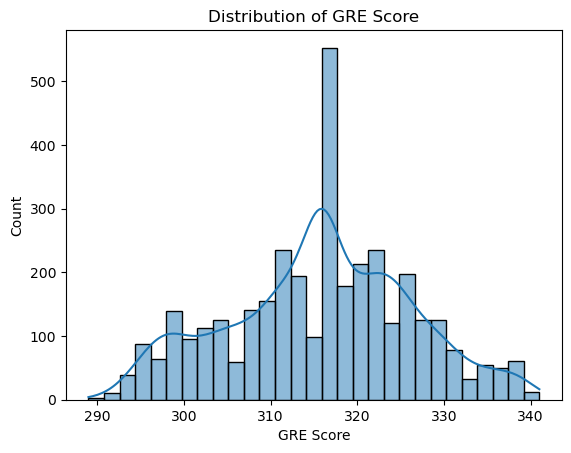

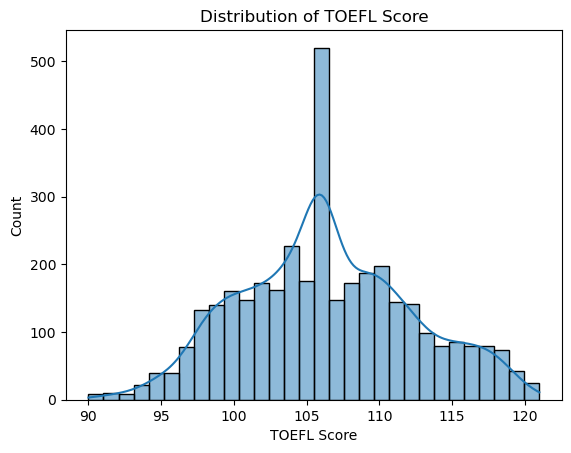

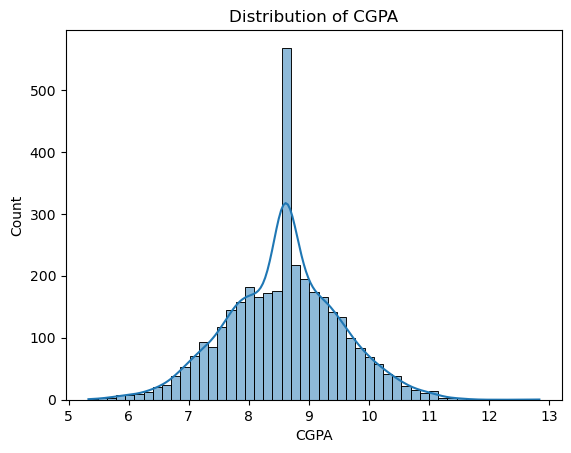

In [9]:
# Plot distributions of key features
num_features = ['GRE Score', 'TOEFL Score', 'CGPA']
for col in num_features:
    sns.histplot(train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [10]:
train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admitted,Age,First_Generation,...,Age_bin_Senior,GRE_bin,TOEFL_bin,CGPA_bin,GRE Score_scaled,TOEFL Score_scaled,CGPA_scaled,Academic_Score,GRE_TOEFL_interaction,GRE_outlier
0,319.0,111.0,4,4.78,4.89,9.51,1,1,26,1,...,False,2,3,3,0.310780,0.789861,0.994009,0.698216,35409.0,0
1,327.0,113.0,5,4.24,4.74,10.19,1,1,23,1,...,False,3,3,3,1.064948,1.129322,1.720205,1.304825,36951.0,0
2,323.0,110.0,4,3.43,2.99,8.81,1,1,32,0,...,True,2,2,2,0.687864,0.620130,0.246453,0.518149,35530.0,0
3,321.0,105.0,3,3.41,3.38,8.60,0,0,34,1,...,True,2,1,1,0.499322,-0.228524,0.022186,0.097662,33705.0,0
4,316.0,108.0,3,3.40,4.80,8.60,1,1,30,1,...,False,1,2,1,0.027967,0.280669,0.022186,0.110274,34128.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,318.0,109.0,2,3.62,3.99,8.76,1,1,22,0,...,False,2,2,2,0.216509,0.450399,0.193056,0.286655,34662.0,0
3596,313.0,98.0,4,3.09,3.86,9.25,1,1,27,0,...,False,1,0,3,-0.254846,-1.416639,0.716345,-0.318380,30674.0,0
3597,316.0,118.0,4,4.51,3.35,9.23,1,1,22,0,...,False,1,3,3,0.027967,1.977976,0.694986,0.900310,37288.0,0
3598,322.0,106.0,5,4.04,3.86,9.27,1,1,27,1,...,False,2,1,3,0.593593,-0.058793,0.737704,0.424168,34132.0,0


## 🧹 Preprocessing
We’ll split the data into features and target, and then into training and validation sets.


In [11]:
# Features and target
X = train.drop(columns=['Admitted'])
y = train['Admitted']

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape


((2880, 24), (720, 24))

## 🤖 Model Training
We’ll use a simple Random Forest classifier as our baseline model.


In [12]:
# Train a Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [13]:
# Train a Random Forest
model_1 = CatBoostClassifier(random_state=42)
model_1.fit(X_train, y_train)


Learning rate set to 0.016184
0:	learn: 0.6771158	total: 152ms	remaining: 2m 31s
1:	learn: 0.6618706	total: 157ms	remaining: 1m 18s
2:	learn: 0.6471018	total: 161ms	remaining: 53.6s
3:	learn: 0.6333843	total: 165ms	remaining: 41s
4:	learn: 0.6160680	total: 168ms	remaining: 33.5s
5:	learn: 0.6026007	total: 172ms	remaining: 28.4s
6:	learn: 0.5918847	total: 174ms	remaining: 24.7s
7:	learn: 0.5816905	total: 178ms	remaining: 22.1s
8:	learn: 0.5704887	total: 182ms	remaining: 20.1s
9:	learn: 0.5554438	total: 186ms	remaining: 18.4s
10:	learn: 0.5421794	total: 189ms	remaining: 17s
11:	learn: 0.5332701	total: 194ms	remaining: 16s
12:	learn: 0.5247966	total: 198ms	remaining: 15.1s
13:	learn: 0.5128510	total: 203ms	remaining: 14.3s
14:	learn: 0.5054342	total: 209ms	remaining: 13.7s
15:	learn: 0.4948591	total: 213ms	remaining: 13.1s
16:	learn: 0.4860438	total: 219ms	remaining: 12.6s
17:	learn: 0.4782138	total: 224ms	remaining: 12.2s
18:	learn: 0.4719237	total: 228ms	remaining: 11.8s
19:	learn: 0.46

In [14]:
# Train a Random Forest
model_2 = XGBClassifier(random_state=42)
model_2.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [15]:
# Train a Random Forest
model_3 = LGBMClassifier(random_state=42)
model_3.fit(X_train, y_train)


c:\Users\Timmy-afolami\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Timmy-afolami\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Timmy-afolami\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Timmy-afolami\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Timmy-afolami\anaconda3\Lib\subprocess.py", line 1538, in _execute_child


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1923, number of negative: 957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1750
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.667708 -> initscore=0.697838
[LightGBM] [Info] Start training from score 0.697838


LGBMClassifier(random_state=42)

In [16]:
from sklearn.metrics import f1_score

In [17]:
# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))

Accuracy: 0.8305555555555556
F1 Score: 0.8279272624951637
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       248
           1       0.85      0.90      0.87       472

    accuracy                           0.83       720
   macro avg       0.82      0.80      0.81       720
weighted avg       0.83      0.83      0.83       720



In [18]:
# Predict on validation set
y_pred = model_1.predict(X_val)

# Evaluate
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))


Accuracy: 0.8472222222222222
F1 Score: 0.8450439911286588
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       248
           1       0.86      0.91      0.89       472

    accuracy                           0.85       720
   macro avg       0.84      0.82      0.83       720
weighted avg       0.85      0.85      0.85       720



In [19]:
# Predict on validation set
y_pred = model_2.predict(X_val)

# Evaluate
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))


Accuracy: 0.8305555555555556
F1 Score: 0.8274904214559387
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       248
           1       0.85      0.90      0.88       472

    accuracy                           0.83       720
   macro avg       0.82      0.80      0.81       720
weighted avg       0.83      0.83      0.83       720



In [20]:
# Predict on validation set
y_pred = model_3.predict(X_val)

# Evaluate
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))


Accuracy: 0.8416666666666667
F1 Score: 0.8390084985003512
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       248
           1       0.86      0.91      0.88       472

    accuracy                           0.84       720
   macro avg       0.83      0.81      0.82       720
weighted avg       0.84      0.84      0.84       720



Accuracy: 0.8305555555555556

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       248
           1       0.85      0.90      0.87       472

    accuracy                           0.83       720
   macro avg       0.82      0.80      0.81       720
weighted avg       0.83      0.83      0.83       720



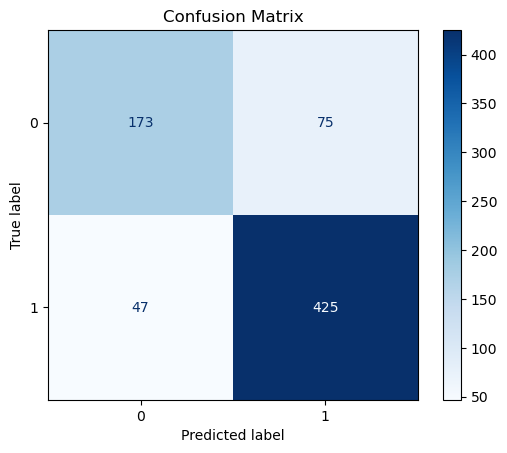

In [21]:
# 📈 Evaluate Model on Validation Set

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Predict on validation data
y_pred = model.predict(X_val)

# Accuracy score
print("Accuracy:", accuracy_score(y_val, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


## 📊 Feature Importance
Let’s see which features are most important to the model.

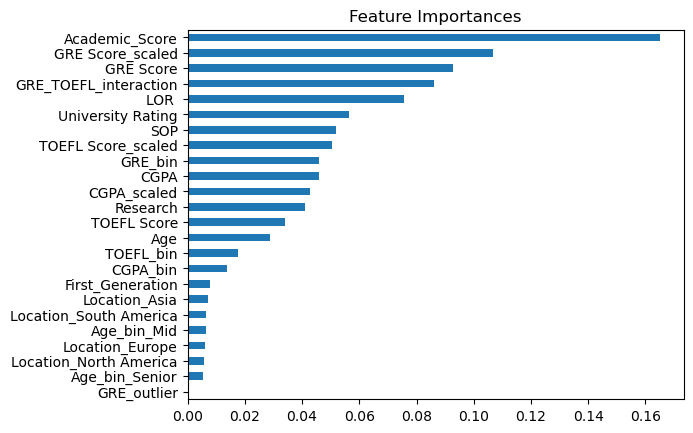

In [22]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()


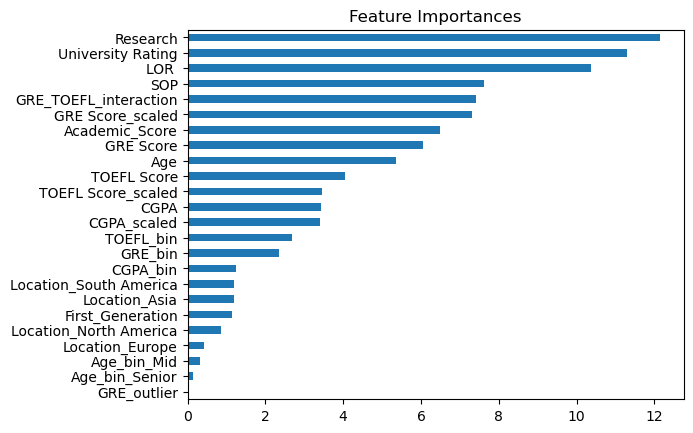

In [23]:
importances = pd.Series(model_1.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()


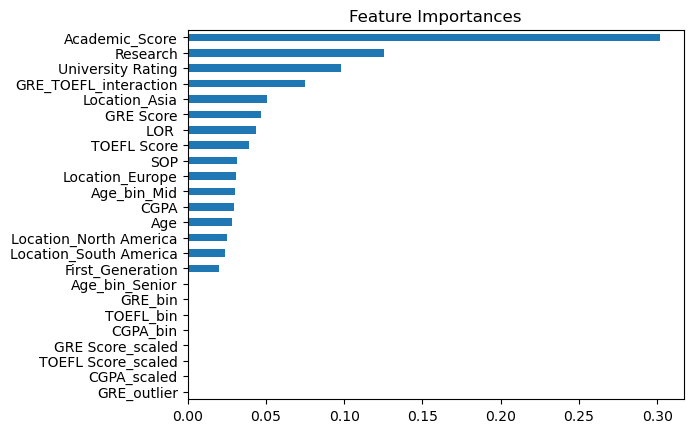

In [24]:
importances = pd.Series(model_2.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()


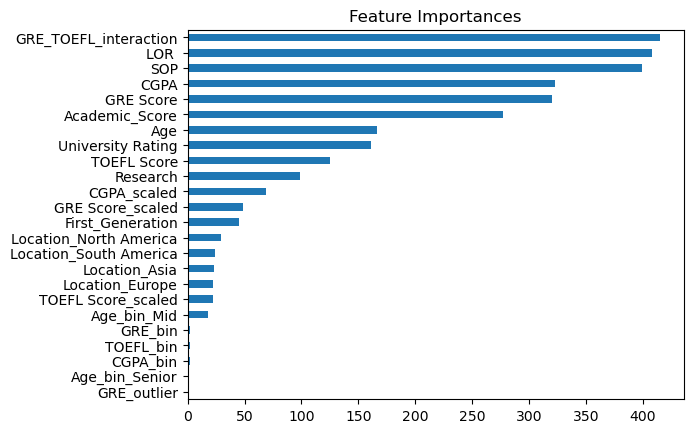

In [25]:
importances = pd.Series(model_3.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()


## 🚀 Predictions on Test Set
Let’s predict on the test set and generate a submission file.


In [26]:
test_predictions = model.predict(test.drop("ID", axis=1))

# Prepare submission
submission = sample_submission.copy()
submission['Admitted'] = test_predictions

# Save to CSV
submission.to_csv('submission_1.csv', index=False)
print("Submission file saved!")


Submission file saved!


In [27]:
test_predictions = model_1.predict(test.drop("ID", axis=1))

# Prepare submission
submission = sample_submission.copy()
submission['Admitted'] = test_predictions

# Save to CSV
submission.to_csv('submission_1.csv', index=False)
print("Submission file saved!")


Submission file saved!


In [28]:
test_predictions = model_2.predict(test.drop("ID", axis=1))

# Prepare submission
submission = sample_submission.copy()
submission['Admitted'] = test_predictions

# Save to CSV
submission.to_csv('submission_2.csv', index=False)
print("Submission file saved!")


Submission file saved!


In [29]:
test_predictions = model_3.predict(test.drop("ID", axis=1))

# Prepare submission
submission = sample_submission.copy()
submission['Admitted'] = test_predictions

# Save to CSV
submission.to_csv('submission_3.csv', index=False)
print("Submission file saved!")


Submission file saved!


## ✅ What’s Next?

This is just a baseline model! You can improve your score by:
- Trying other models (Logistic Regression, XGBoost, etc.)
- Feature scaling or transformation
- Hyperparameter tuning
- Model ensembling

Good luck, and happy modeling! 💪


### Hosts: Olufemi Victor Tolulope & Olaleye Eniola

Victor's Socials:

- [Twitter](https://twitter.com/olufemivictort)
- [LinkedIn](https://www.linkedin.com/in/olufemi-victor-tolulope)
- [website](https://www.olufemivictor.com/)

Eniola's Socials
- [Twitter](https://x.com/galileoeni)
- [LinkedIn](https://www.linkedin.com/in/eniola-olaleye-361b39160)
- [website](https://galileoeni.github.io/galileo/)